# Imports

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import pickle
%matplotlib inline

# Find corners of undistort images

In [3]:
chessboard_output_folder = 'output_images/chessboard/'
images_with_corners = []
img_size = ()

objp = np.zeros((9*6, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    name = fname.split("/")[-1].split(".")[0]
    if not img_size:
        img_size = (img.shape[1], img.shape[0])
    else:
        if (img.shape[1], img.shape[0]) != img_size:
            print(fname, img.shape[:2], " has different image size", img_size)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (9, 6), corners, ret)
#         mpimg.imsave(chessboard_output_folder + name + "_corner.jpg", img)
        images_with_corners.append(fname)
    else:
        print(fname, "has no corners")


# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    name = fname.split("/")[-1].split(".")[0]
#     mpimg.imsave(chessboard_output_folder + name + "_original.jpg", img)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
#     mpimg.imsave(chessboard_output_folder + name + "_undistort.jpg", dst)


# Test against example images
example_output_folder = 'output_images/examples/'

example_images = glob.glob('test_images/*.jpg')
for example_fname in example_images:
    example_img = mpimg.imread(example_fname)
    name = example_fname.split("/")[-1].split(".")[0]
#     mpimg.imsave(example_output_folder + name + "_original.jpg" , example_img)
    example_dst = cv2.undistort(example_img, mtx, dist, None, mtx)
#     mpimg.imsave(example_output_folder + name + "_undistort.jpg" , example_dst)

camera_cal/calibration5.jpg has no corners
camera_cal/calibration4.jpg has no corners
camera_cal/calibration7.jpg (721, 1281)  has different image size (1280, 720)
camera_cal/calibration1.jpg has no corners
camera_cal/calibration15.jpg (721, 1281)  has different image size (1280, 720)


# Color & Gradient Thresholding

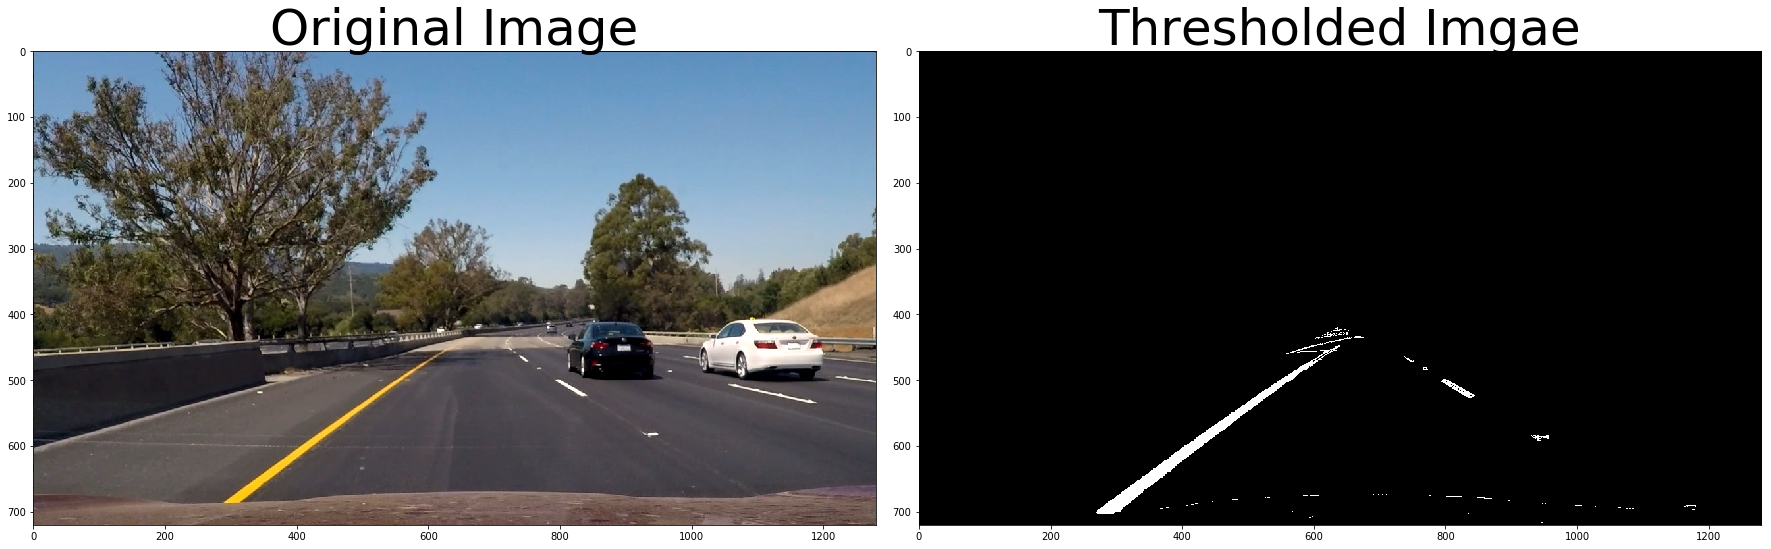

In [4]:
# Read in an image

image = mpimg.imread(example_images[0])

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobelxy)
    # 6) Return this mask as your binary_output image
    binary_output[(mag_thresh[0] <= scaled_sobelxy) & (scaled_sobelxy <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sobel_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(sobel_dir)
    binary_output[(sobel_dir >= thresh[0]) & (sobel_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def hls_threshold(img, s_thresh=(0, 255), h_thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])
                 & (h_channel > h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def rgb_threshold(img, r_thresh=(0, 255), g_thresh=(0, 255), b_thresh=(0, 255)):
    # 2) Apply a threshold to the S channel
    r_channel = img[:,:,0]
    g_channel = img[:,:,1]
    b_channel = img[:,:,2]
    binary_output = np.zeros_like(r_channel)
    binary_output[(r_channel > r_thresh[0]) & (r_channel <= r_thresh[1])
                 & (g_channel > g_thresh[0]) & (g_channel <= g_thresh[1])
                 & (b_channel > b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

# function defined in Project1
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def apply_threshold(image):
    gradx_binary = abs_sobel_thresh(image, orient='x', thresh_min=30, thresh_max=230)
    grady_binary = abs_sobel_thresh(image, orient='y', thresh_min=30, thresh_max=230)
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(80, 150))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(np.pi/6, np.pi/2))
    hls_binary = hls_threshold(image, s_thresh=(90, 255), h_thresh=(15, 100))
    rgb_binary = rgb_threshold(image, r_thresh=(100, 255), g_thresh=(100, 255), b_thresh=(200, 255))
    
    combined_binary = np.zeros_like(gradx_binary)
    combined_binary[
        (hls_binary == 1) |
        ((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    vertices = np.array([[(10, image.shape[0]),
                          (image.shape[1]/2-5, 420),
                          (image.shape[1]/2+5, 420),
                          (image.shape[1]-10, image.shape[0])]], dtype=np.int32)
    combined_binary = region_of_interest(combined_binary, vertices)
    return combined_binary

undist_image = cv2.undistort(image, mtx, dist, None, mtx)
combined_binary = apply_threshold(undist_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Thresholded Imgae', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective Transform

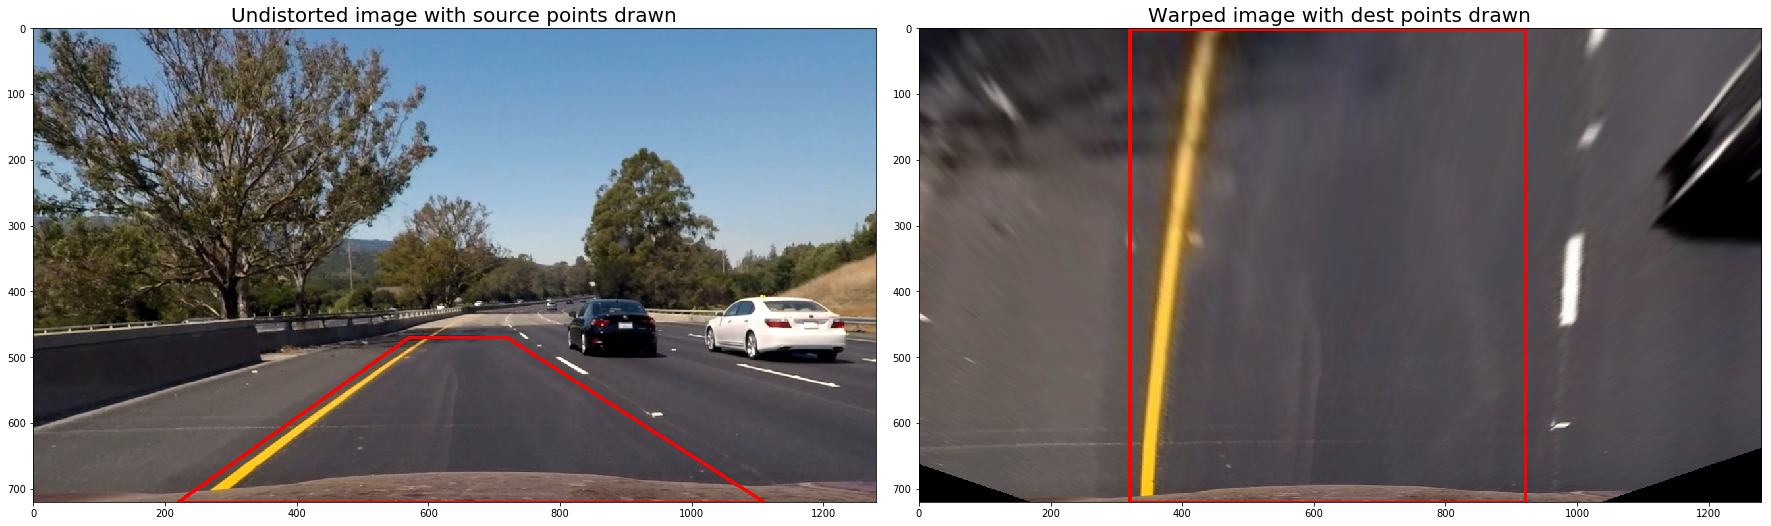

In [5]:
def get_region_image(image, vertices):
    points = np.array([vertices], np.int32).reshape((-1,1,2))
    region_image = image.copy()
    cv2.polylines(region_image, [points], True, (255, 0, 0), thickness=3)
    return region_image

def get_warped_image(image):
    src = np.float32([(220, undist_image.shape[0]), 
                      (570, 470), 
                      (720, 470),
                      (1110, undist_image.shape[0])])
    dst = np.float32([(320, image.shape[0]), 
                      (320, 0), 
                      (920, 0),
                      (920, image.shape[0])])
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    img_size = (image.shape[1], image.shape[0])
    warped_image = cv2.warpPerspective(image, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped_image, M_inv


def show_warp_region_image(undist_image, warped_image):
    src = np.float32([(220, undist_image.shape[0]), 
                      (570, 470), 
                      (720, 470),
                      (1110, undist_image.shape[0])])
    dst = np.float32([(320, undist_image.shape[0]), 
                      (320, 1), 
                      (920, 1),
                      (920, undist_image.shape[0])])

    undist_region_image = get_region_image(undist_image, src)
    warped_region_image = get_region_image(warped_image, dst)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist_region_image)
    ax1.set_title('Undistorted image with source points drawn', fontsize=20)
    ax2.imshow(warped_region_image, cmap='gray')
    ax2.set_title('Warped image with dest points drawn', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

undist_image = cv2.undistort(image, mtx, dist, None, mtx)
warped_image, _ = get_warped_image(undist_image)
show_warp_region_image(undist_image, warped_image)

# Finding lanes

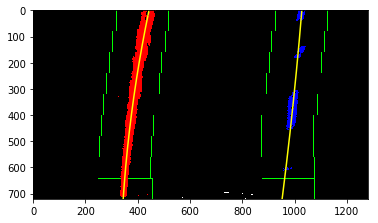

In [6]:
binary_warped, M_inv = get_warped_image(combined_binary)

def find_fit_lanes(binary_warped, show_lanes=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # plt.plot(histogram)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if show_lanes:
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    return left_fitx, right_fitx, left_fit, right_fit

left_fitx, right_fitx, left_fit, right_fit = find_fit_lanes(binary_warped, show_lanes=True)

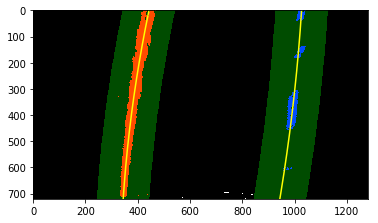

In [7]:
def find_lanes(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
find_lanes(binary_warped, left_fit, right_fit)

# Measuring Curvature

In [8]:
def measure_curvature(left_fitx, right_fitx):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    avg_curverad = (left_curverad + right_curverad)/2
    
    lane_center = (left_fitx[-1] + right_fitx[-1])/2
    center_offset_pixels = abs(image.shape[0]/2 - lane_center)
    center_offset = xm_per_pix*center_offset_pixels

    return avg_curverad, center_offset

measure_curvature(left_fitx, right_fitx)

(3488.1896867748028, 1.5250833590171782)

# Inverse Transform

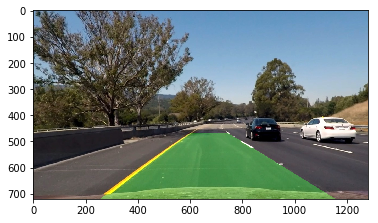

In [9]:
def inverse_transform(undist_image, binary_warped, M_inv, left_fitx, right_fitx, show_image=False):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
#     plt.imshow(color_warp)
#     plt.show()

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (undist_image.shape[1], undist_image.shape[0])) 
#     plt.imshow(newwarp)
#     plt.show()
    
#     print(undist_image.shape)
#     print(newwarp.shape)
#     print(undist_image)
#     print(newwarp)
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    if show_image:
        plt.imshow(result)
        plt.show()
    return result

inverse_image = inverse_transform(undist_image, binary_warped, M_inv, left_fitx, right_fitx, show_image=True)

# Pipeline

In [10]:
def process_image(image, show_result=False):
    undist_image = cv2.undistort(image, mtx, dist, None, mtx)
#     plt.imshow(undist_image)
#     plt.show()

    try:
        combined_binary = apply_threshold(undist_image)
#         plt.imshow(combined_binary)
#         plt.show()

        binary_warped, M_inv = get_warped_image(combined_binary)
#         plt.imshow(binary_warped)
#         plt.show()

#         show_warp_region_image(undist_image, binary_warped)

        left_fitx, right_fitx, _, _ = find_fit_lanes(binary_warped, show_lanes=False)
            
        inverse_image = inverse_transform(undist_image, binary_warped, M_inv, left_fitx, right_fitx)

        avg_curverand, center_offset = measure_curvature(left_fitx, right_fitx)

        cv2.putText(inverse_image, "radius of curvature: %.2f m" % avg_curverand, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
        cv2.putText(inverse_image, "lane offset: %.2f m" % center_offset, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    except:
        invalid_name = str(int(time.time()))
        mpimg.imsave('output_images/invalid/' + invalid_name + ".jpg", image)
        return image
    
    if show_result:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(inverse_image, cmap='gray')
        ax2.set_title('Final Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
    
    return inverse_image
#     return undist_image, combined_binary, binary_warped, inverse_image

#     name = fname.split("/")[-1].split(".")[0]
#     mpimg.imsave(example_output_folder + name + "_original.jpg", image)
#     mpimg.imsave(example_output_folder + name + "_undistort.jpg", undist_image)
#     mpimg.imsave(example_output_folder + name + "_binary.jpg", combined_binary)
#     mpimg.imsave(example_output_folder + name + "_warped.jpg", binary_warped)
#     mpimg.imsave(example_output_folder + name + "_final.jpg", inverse_image)

# Debug image frames

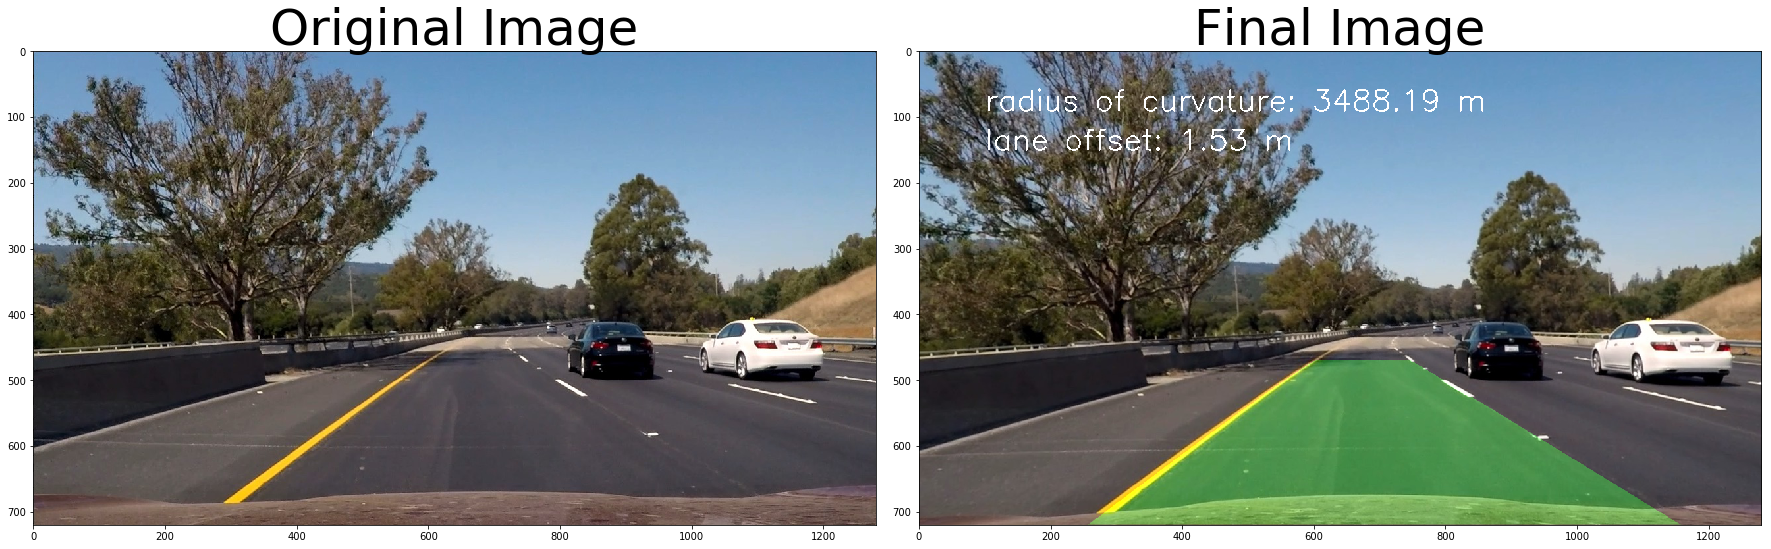

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


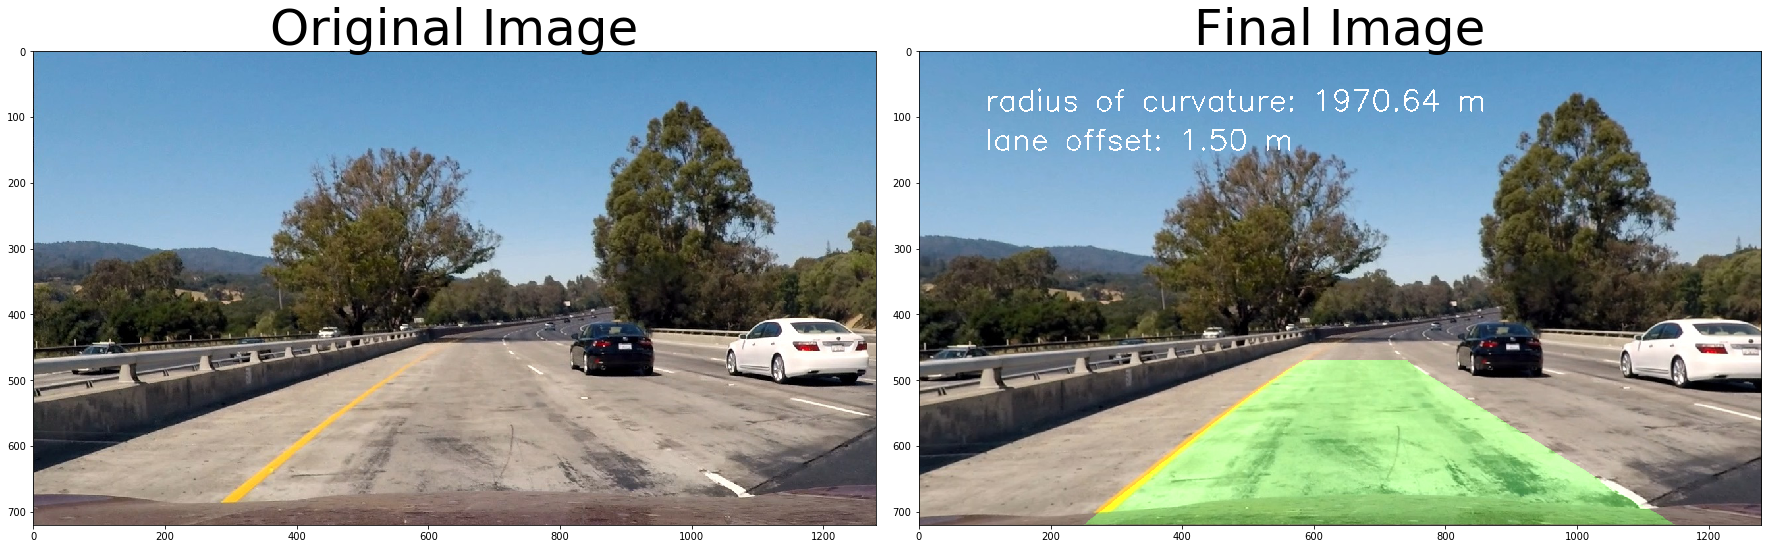

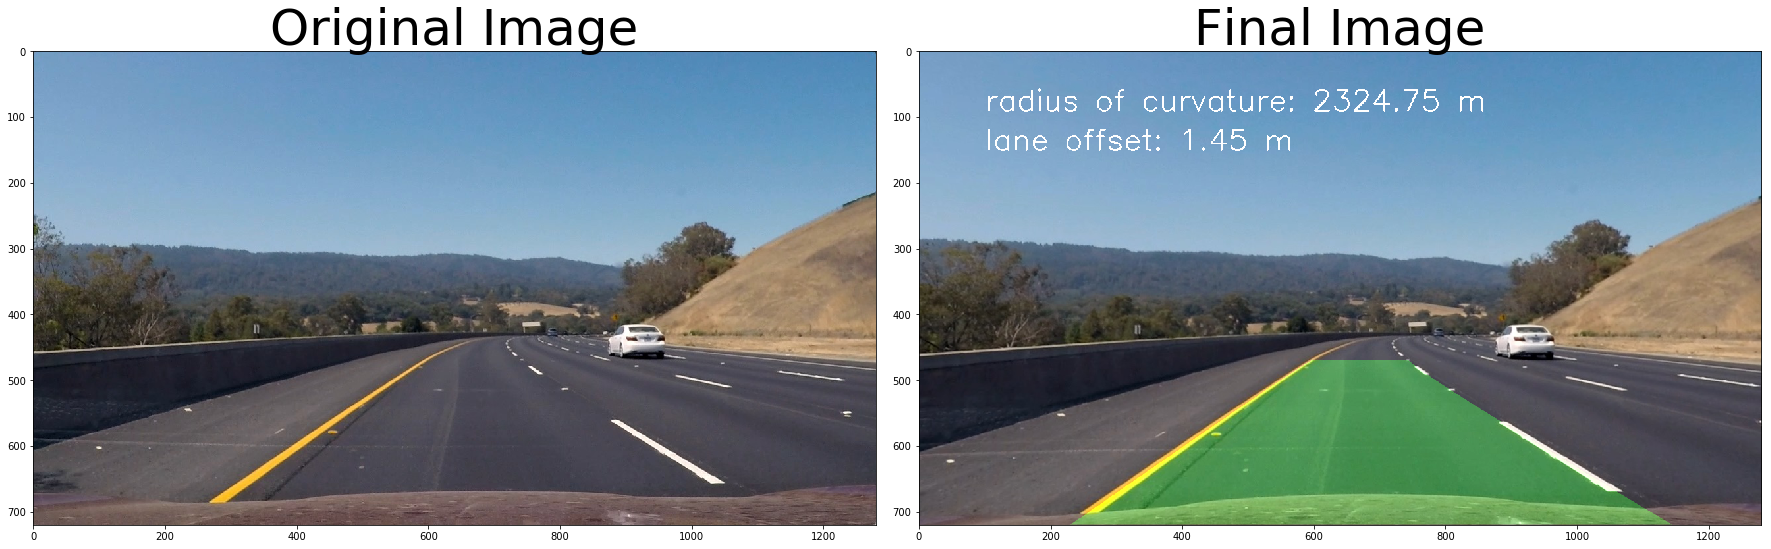

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


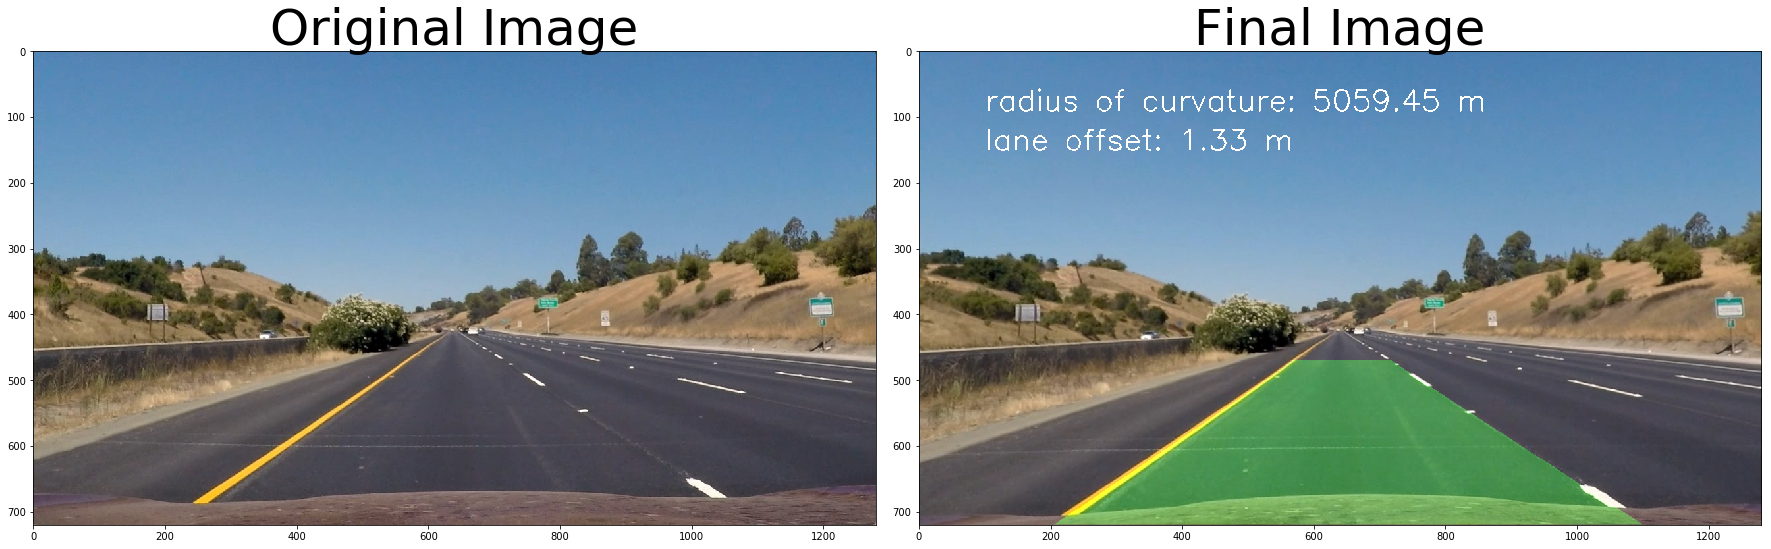

In [11]:
images = glob.glob('test_images/*.jpg')
for fname in images:
    image = mpimg.imread(fname)
    final_image = process_image(image, show_result=True)

In [ ]:
images = glob.glob('test_images2/*.jpg')
for fname in images:
    image = mpimg.imread(fname)
    image = image[:,:,:3]
    final_image = process_image(image, show_result=True)

# Video

In [18]:
from moviepy.editor import VideoFileClip
output = 'project_video_output2.mp4'
clip = VideoFileClip("project_video.mp4")
new_clip = clip.fl_image(process_image)
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output2.mp4
[MoviePy] Writing video project_video_output2.mp4


  4%|▎         | 46/1261 [00:07<04:16,  4.74it/s]


OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file project_video_output2.mp4:

 b''

In [17]:
import imageio
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg.osx' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.osx (28.8 MB)


Downloading: 8192/30241064 bytes (0.016384/30241064 bytes (0.1%32768/30241064 bytes (0.1%65536/30241064 bytes (0.2%114688/30241064 bytes (0.4163840/30241064 bytes (0.5180224/30241064 bytes (0.6245760/30241064 bytes (0.8294912/30241064 bytes (1.0327680/30241064 bytes (1.1360448/30241064 bytes (1.2409600/30241064 bytes (1.4442368/30241064 bytes (1.5475136/30241064 bytes (1.6491520/30241064 bytes (1.6540672/30241064 bytes (1.8573440/30241064 bytes (1.9589824/30241064 bytes (2.0606208/30241064 bytes (2.0622592/30241064 bytes (2.1638976/30241064 bytes (2.1671744/30241064 bytes (2.2688128/30241064 bytes (2.3704512/30241064 bytes (2.3737280/30241064 bytes (2.4753664/30241064 bytes (2.5770048/30241064 bytes (2.5786432/30241064 bytes (2.6802816/30241064 bytes (2.7819200/30241064 bytes (2.7835584/30241064 bytes (2.8851968/30241064 bytes (2.8868352/30241064 bytes (2.9884736/30241064 bytes (2.9909312/30241064 bytes (3.0917504/30241064 bytes (3.0925696/30241064 bytes (3.1933888/30241064 bytes (3.19

9781248/30241064 bytes (32.39814016/30241064 bytes (32.59846784/30241064 bytes (32.69879552/30241064 bytes (32.79912320/30241064 bytes (32.89961472/30241064 bytes (32.99994240/30241064 bytes (33.010027008/30241064 bytes (33.2%10059776/30241064 bytes (33.3%10092544/30241064 bytes (33.4%10108928/30241064 bytes (33.4%10125312/30241064 bytes (33.5%10158080/30241064 bytes (33.6%10190848/30241064 bytes (33.7%10207232/30241064 bytes (33.8%10240000/30241064 bytes (33.9%10272768/30241064 bytes (34.0%10305536/30241064 bytes (34.1%10338304/30241064 bytes (34.2%10371072/30241064 bytes (34.3%10387456/30241064 bytes (34.3%10403840/30241064 bytes (34.4%10420224/30241064 bytes (34.5%10436608/30241064 bytes (34.5%10452992/30241064 bytes (34.6%10502144/30241064 bytes (34.7%10518528/30241064 bytes (34.8%10551296/30241064 bytes (34.9%10584064/30241064 bytes (35.0%10616832/30241064 bytes (35.1%10649600/30241064 bytes (35.2%10682368/30241064 bytes (35.3%10715136/30241064 bytes (35.4%10747904/30241064 bytes 

20103168/30241064 bytes (66.5%20135936/30241064 bytes (66.6%20152320/30241064 bytes (66.6%20168704/30241064 bytes (66.7%20185088/30241064 bytes (66.7%20217856/30241064 bytes (66.9%20234240/30241064 bytes (66.9%20267008/30241064 bytes (67.0%20283392/30241064 bytes (67.1%20299776/30241064 bytes (67.1%20316160/30241064 bytes (67.2%20332544/30241064 bytes (67.2%20348928/30241064 bytes (67.3%20365312/30241064 bytes (67.3%20398080/30241064 bytes (67.5%20430848/30241064 bytes (67.6%20463616/30241064 bytes (67.7%20496384/30241064 bytes (67.8%20529152/30241064 bytes (67.9%20561920/30241064 bytes (68.0%20594688/30241064 bytes (68.1%20627456/30241064 bytes (68.2%20660224/30241064 bytes (68.3%20676608/30241064 bytes (68.4%20692992/30241064 bytes (68.4%20709376/30241064 bytes (68.5%20725760/30241064 bytes (68.5%20742144/30241064 bytes (68.6%20758528/30241064 bytes (68.6%20791296/30241064 bytes (68.8%20807680/30241064 bytes (68.8%20856832/30241064 bytes (69.0%20873216/30241064 bytes (69.0%20889600/

26034176/30241064 bytes (86.1%26050560/30241064 bytes (86.1%26066944/30241064 bytes (86.2%26083328/30241064 bytes (86.3%26099712/30241064 bytes (86.3%26116096/30241064 bytes (86.4%26132480/30241064 bytes (86.4%26148864/30241064 bytes (86.5%26165248/30241064 bytes (86.5%26198016/30241064 bytes (86.6%26214400/30241064 bytes (86.7%26230784/30241064 bytes (86.7%26247168/30241064 bytes (86.8%26263552/30241064 bytes (86.8%26279936/30241064 bytes (86.9%26296320/30241064 bytes (87.0%26320896/30241064 bytes (87.0%26329088/30241064 bytes (87.1%26337280/30241064 bytes (87.1%26345472/30241064 bytes (87.1%26361856/30241064 bytes (87.2%26378240/30241064 bytes (87.2%26394624/30241064 bytes (87.3%26411008/30241064 bytes (87.3%26427392/30241064 bytes (87.4%26443776/30241064 bytes (87.4%26460160/30241064 bytes (87.5%26476544/30241064 bytes (87.6%26501120/30241064 bytes (87.6%26509312/30241064 bytes (87.7%26517504/30241064 bytes (87.7%26525696/30241064 bytes (87.7%26542080/30241064 bytes (87.8%26566656/